# Evaluer un modèle entrainé et sauvegardé

## Imports

In [15]:
# import des librairies nécessaires :
import import_ipynb

# On importe le notebook dataset_utils et sa fonction Subset :
from dataset_utils import Subset

# On importe le notebook training_utils et ses fonctions :
from training_utils import  CustomDataset, ImageProcessor, LabelMap


from torch import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

In [16]:
# On récupère le nom de la classe à partir du label et de la prédiction dans style_names.csv
style_names = pd.read_csv('../dataset_doc/csv/style_names.csv',header=None)
# on nomme les colonnes du dataframe
style_names.columns = ['label','style']
display(style_names)

,label,style
0,Q578577,Early English Gothic
1,Q12049741,Romantic Architecture
2,Q966571,Byzantine Revival Architecture
3,Q6092662,Italian Baroque
4,Q2884586,Italian Romanesque Architecture
...,...,...
116,Q13107150,Czech Baroque
117,Q13526807,Neues Bauen
118,Q4198718,Classical Architecture
119,Q47591,Byzantine Architecture


In [17]:
# On crée une fonction qui évalue l'accuracy du modèle sur le val set
def evaluate_model(model, dataloader, path, label_map):
    correct = 0
    total = 0
    mean_trust = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            mean_trust += torch.mean(torch.max(outputs.data,1).values)
            total += len(labels)
            correct += (predicted == labels).sum().item()

    # On pioche 4 images au hasard dans le val set et on affiche leur prédiction

    # On récupère les images et les labels
    images, labels = next(iter(dataloader))

    # On affiche les images, les labels et les prédictions sur la même figure
    fig = plt.figure(figsize=(10, 10))

    for i in range(4):
        # On affiche l'image
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))
        # On récupère la prédiction
        with torch.no_grad():
            outputs = model(images[i].unsqueeze(0))
            _, predicted = torch.max(outputs.data, 1)
        # On affiche le label et la prédiction
        # On récupère la key dans le dictionnaire label_map à partir de la valeur
        label = list(label_map.keys())[list(label_map.values()).index(labels[i].item())]
        prediction = list(label_map.keys())[list(label_map.values()).index(predicted.item())]

        # On récupère le nom de la classe à partir du label et de la prédiction dans style_names
        label = style_names[style_names['label'] == label]['style'].item()
        prediction = style_names[style_names['label'] == prediction]['style'].item()
        
        ax.set_title(f'Label: {label}\nPrediction: {prediction}')
        ax.axis('off')

    plt.show()

    # On sauvegarde la performance du modèle dans un fichier texte 
    f = open(path + '/performance.txt','w')
    f.write('accuracy : ' + str(correct / total * 100) + '%')
    f.write('\n')
    f.write('mean trust : ' + str(mean_trust / total))
    f.close()

    # On retourne l'accuracy en pourcentage
    print(f'Accuracy of the network on the {total} test images: {correct / total * 100} %')
    print(f'Mean trust of the network on the {total} test images: {mean_trust / total}')


,img_name,parent_id,parent_name
0,Q1415669_wd1.jpg,Q840829,Baroque
1,Q12030410_wd0.jpg,Q840829,Baroque
2,Q12031051_wd0.jpg,Q840829,Baroque
3,Q16320906_wd1.jpg,Q840829,Baroque
4,Q223413_wd0.jpg,Q840829,Baroque


(306, 3)

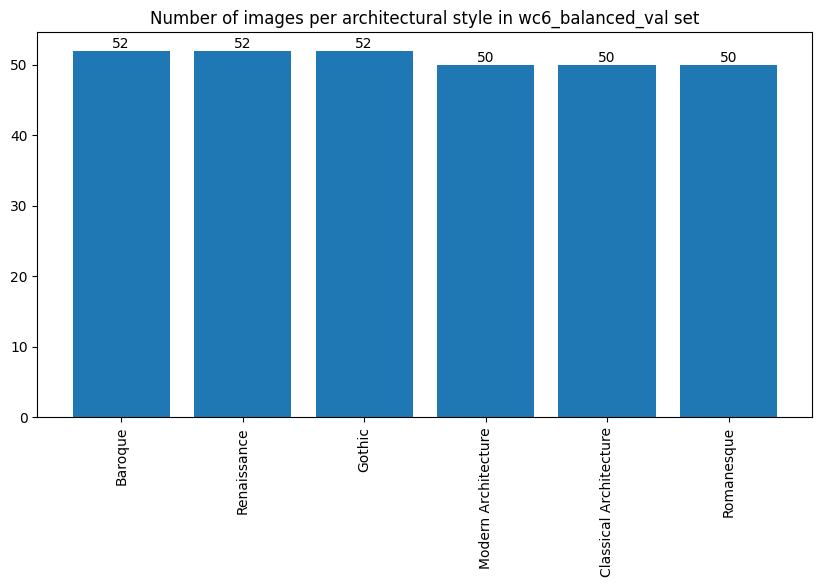

In [18]:
val_set = Subset('../sets/csv/wc6_val.txt.csv', 'wc6_balanced_val')

In [19]:
img_processor = ImageProcessor()
eval_tensors = img_processor.generate_img_tensors(val_set.get_df(),'wc6_256_eval',256)

Dictionnaire créé pour le set wc6_256_eval de taille : 256x256
Nombre d'images dans le set : 306


In [20]:
label_mapper = LabelMap()
# Si le fichier csv label_map.csv existe, on le charge
from os import path

if path.exists('../dataset_doc/csv/label_map.csv'):
    label_map = label_mapper.read_label_map('../dataset_doc/csv/label_map.csv')
else:
    # On créé le label_map
    print('Label map does not exist. It is needed to evaluate the model. Please launch main.ipynb before evaluating models.')

Found label mapping, reading it...
Label mapping is the following :


{'Q176483': 0,
 'Q46261': 1,
 'Q840829': 2,
 'Q236122': 3,
 'Q245188': 4,
 'Q4198718': 5}

In [21]:
dataset_val = CustomDataset(eval_tensors,  val_set.get_df(), label_map)

## Chemin vers le modèle à évaluer

In [22]:
model_folder_path = '../saved_models/model_resnet18_13_01_2024_13_15_35/'
model_path = model_folder_path+'/model.pth'

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Choix de la classe du modèle

### Modèle de CNN personnalisé

In [24]:
#from network import Net
# On charge le modèle custom si l'on souhaite l'évaluer
#model = Net()

### Modèle ResNet18

In [25]:
import torchvision.models as models
model = models.resnet18(pretrained=True)
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
set_parameter_requires_grad(model)
model.fc = nn.Linear(512,6)

C:\Users\scedr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\scedr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
model.load_state_dict(torch.load(model_path))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
from torch.utils.data import DataLoader

# On crée le dataloader :
eval_dataloader =  DataLoader(dataset_val, batch_size=4, shuffle=True)

## Résultats de l'évaluation du modèle

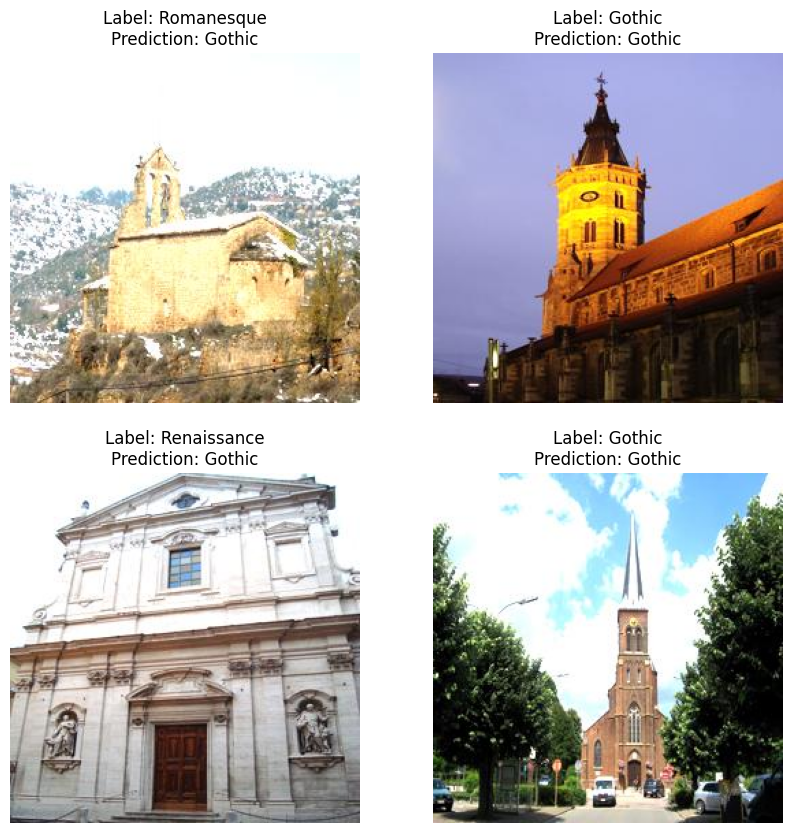

Accuracy of the network on the 306 test images: 37.58169934640523 %
Mean trust of the network on the 306 test images: 0.26269492506980896


In [32]:
# On évalue le modèle :
evaluate_model(model, eval_dataloader, model_folder_path, label_map)